In [1]:
import sys

# New Section


In [2]:
# To add your own Drive Run this cell.
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# Please append your own directory after ‘/content/drive/My Drive/'
# where you have nutil.py and adult_subsample.csv
### ========== START ========== ###
# sys.path += ['/content/drive/My Drive/cm146-2024-homeworks/PS1'] # example path
# sys.path += ['./'] # your path

### ========== END ========== ###

In [4]:
from nutil import *

In [5]:
# Use only the provided packages!
import math
import csv

from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import matplotlib.pyplot as plt

In [6]:
######################################################################
# Immutable classes
######################################################################


class Classifier(object):
    """
    Classifier interface.
    """

    def fit(self, X, y):
        raise NotImplementedError()

    def predict(self, X):
        raise NotImplementedError()


class MajorityVoteClassifier(Classifier):
    def __init__(self):
        """
        A classifier that always predicts the majority class.

        Attributes
        --------------------
            prediction_ -- majority class
        """
        self.prediction_ = None

    def fit(self, X, y):
        """
        Build a majority vote classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """
        majority_val = Counter(y).most_common(1)[0][0]
        self.prediction_ = majority_val
        return self

    def predict(self, X):
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.prediction_ is None:
            raise Exception("Classifier not initialized. Perform a fit first.")

        n, d = X.shape
        y = [self.prediction_] * n
        return y

In [7]:
######################################################################
# Mutable classes
######################################################################


class RandomClassifier(Classifier):
    def __init__(self):
        """
        A classifier that predicts according to the distribution of the classes.

        Attributes
        --------------------
            probabilities_ -- class distribution dict (key = class, val = probability of class)
        """
        self.probabilities_ = None

    def fit(self, X, y):
        """
        Build a random classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """

        ### ========== START ========== ###
        # part b: set self.probabilities_ according to the training set
        y_counter = Counter(y)
        self.probabilities_ = {
            target_class: frequency / len(y)
            for target_class, frequency in y_counter.items()
        }

        ### ========== END ========== ###

        return self

    def predict(self, X, seed=1234):
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            seed -- integer, random seed

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.probabilities_ is None:
            raise Exception("Classifier not initialized. Perform a fit first.")
        np.random.seed(seed)

        ### ========== START ========== ###
        # part b: predict the class for each test example
        # hint: use np.random.choice (be careful of the parameters)
        y_pred = [
            np.random.choice(
                list(self.probabilities_.keys()), p=list(self.probabilities_.values())
            )
            for _pred in range(X.shape[0])
        ]

        ### ========== END ========== ###

        return y_pred

In [8]:
######################################################################
# Immutable functions
######################################################################


def plot_histograms(X, y, Xnames, yname):
    n, d = X.shape  # n = number of examples, d =  number of features
    fig = plt.figure(figsize=(20, 15))
    ncol = 3
    nrow = d // ncol + 1
    for i in range(d):
        fig.add_subplot(nrow, ncol, i + 1)
        data, bins, align, labels = plot_histogram(
            X[:, i], y, Xname=Xnames[i], yname=yname, show=False
        )
        n, bins, patches = plt.hist(
            data, bins=bins, align=align, alpha=0.5, label=labels
        )
        plt.xlabel(Xnames[i])
        plt.ylabel("Frequency")
        plt.legend()  # plt.legend(loc='upper left')

    plt.savefig("histograms.pdf")


def plot_histogram(X, y, Xname, yname, show=True):
    """
    Plots histogram of values in X grouped by y.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), feature values
        y     -- numpy array of shape (n,), target classes
        Xname -- string, name of feature
        yname -- string, name of target
    """

    # set up data for plotting
    targets = sorted(set(y))
    data = []
    labels = []
    for target in targets:
        features = [X[i] for i in range(len(y)) if y[i] == target]
        data.append(features)
        labels.append("%s = %s" % (yname, target))

    # set up histogram bins
    features = set(X)
    nfeatures = len(features)
    test_range = list(
        range(int(math.floor(min(features))), int(math.ceil(max(features))) + 1)
    )
    if nfeatures < 10 and sorted(features) == test_range:
        bins = test_range + [test_range[-1] + 1]  # add last bin
        align = "left"
    else:
        bins = 10
        align = "mid"

    # plot
    if show == True:
        plt.figure()
        n, bins, patches = plt.hist(
            data, bins=bins, align=align, alpha=0.5, label=labels
        )
        plt.xlabel(Xname)
        plt.ylabel("Frequency")
        plt.legend()  # plt.legend(loc='upper left')
        plt.show()

    return data, bins, align, labels

In [9]:
######################################################################
# Mutable functions
######################################################################


def error(clf, X, y, ntrials=100, test_size=0.2):
    """
    Computes the classifier error over a random split of the data,
    averaged over ntrials runs.

    Parameters
    --------------------
        clf         -- classifier
        X           -- numpy array of shape (n,d), features values
        y           -- numpy array of shape (n,), target classes
        ntrials     -- integer, number of trials

    Returns
    --------------------
        train_error -- float, training error
        test_error  -- float, test error
        f1_score    -- float, test "micro" averaged f1 score
    """

    train_error = 0
    test_error = 0
    f1_score = 0

    ### ========== START ========== ###
    # compute cross-validation error using StratifiedShuffleSplit over ntrials
    stratified_shuffle_split = StratifiedShuffleSplit(
        n_splits=ntrials, test_size=test_size, random_state=69
    )

    for train_index, test_index in stratified_shuffle_split.split(X, y):
        X_train, X_test, y_train, y_test = (
            X[train_index],
            X[test_index],
            y[train_index],
            y[test_index],
        )

        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)

        train_error += 1 - metrics.accuracy_score(y_train, y_pred_train, normalize=True)
        test_error += 1 - metrics.accuracy_score(y_test, y_pred_test, normalize=True)
        f1_score += metrics.f1_score(y_test, y_pred_test)
    train_error /= ntrials
    test_error /= ntrials
    f1_score /= ntrials
    ### ========== END ========== ###

    return train_error, test_error, f1_score

In [10]:
######################################################################
# Immutable functions
######################################################################


def write_predictions(y_pred, filename, yname=None):
    """Write out predictions to csv file."""
    out = open(filename, "wb")
    f = csv.writer(out)
    if yname:
        f.writerow([yname])
    f.writerows(list(zip(y_pred)))
    out.close()

Plotting...


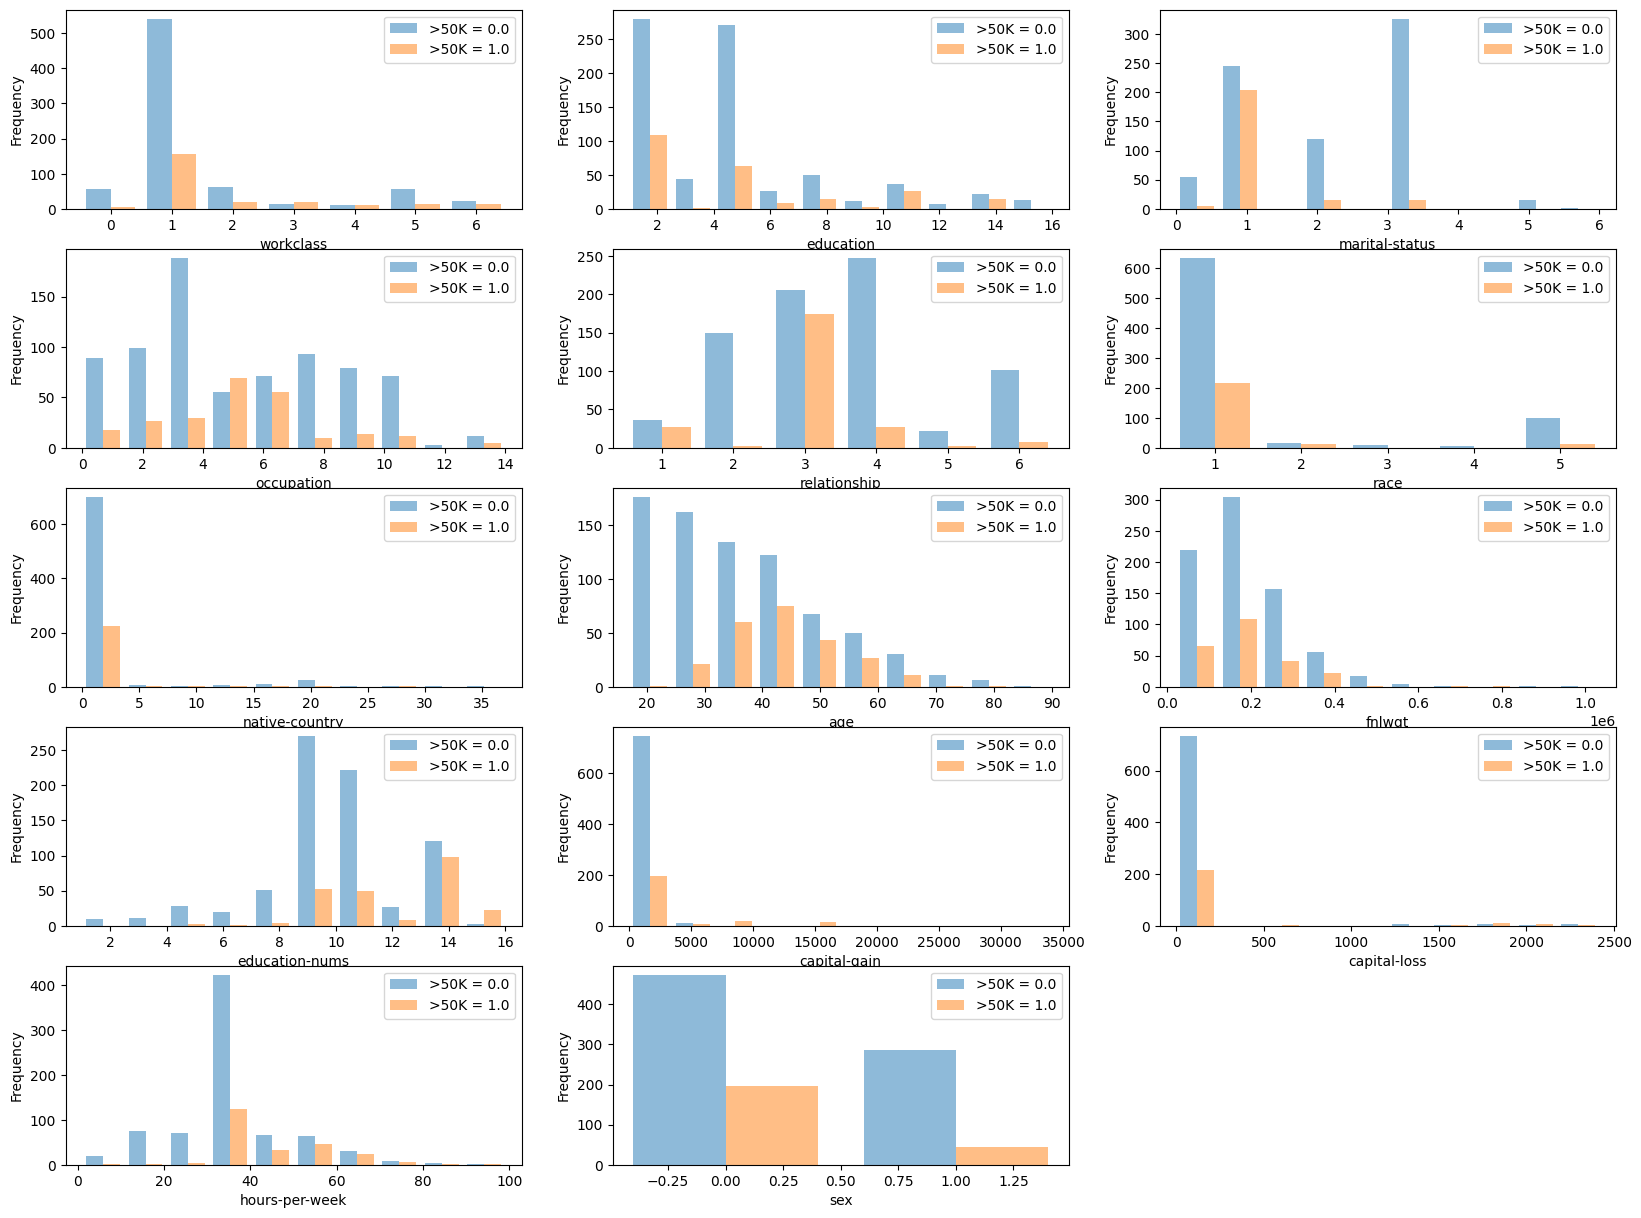

Classifying using Majority Vote...
	-- training error: 0.240
Classifying using Random...
	-- training error: 0.385
Classifying using Decision Tree...
	-- training error: 0.000
Classifying using k-Nearest Neighbors...
0.15300000000000002
0.19499999999999995
0.21299999999999997
Investigating various classifiers...
MajorityVoteClassifier: (0.2399999999999996, 0.2399999999999996, 0.0)
RandomClassifier: (0.3726000000000001, 0.3714, 0.24666451195862926)
DecisionTreeClassifier: (0.0, 0.20639999999999997, 0.5725686773118146)
KNeighborsClassifier: (0.2001250000000001, 0.2537500000000001, 0.16435023174912414)
Finding the best k...
Best k is 15


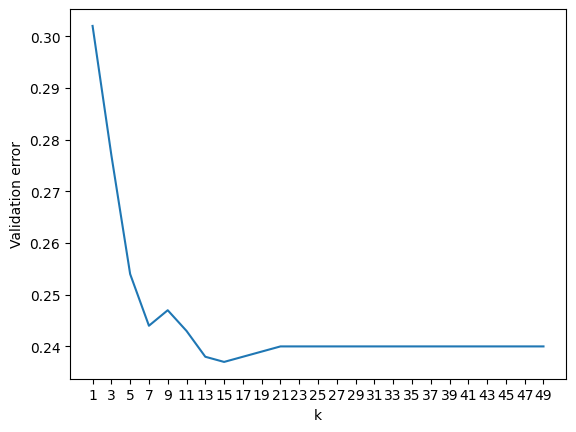

Investigating depths...
Best depth is 5


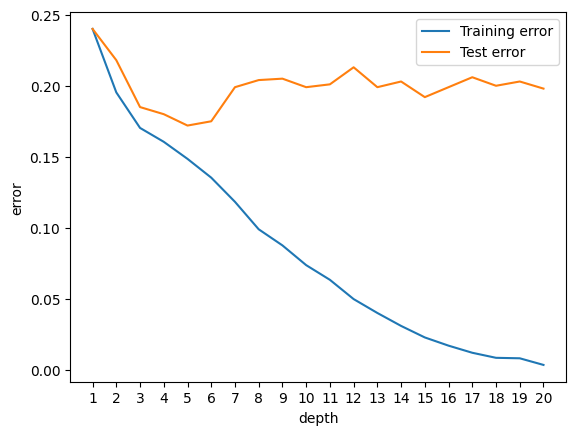

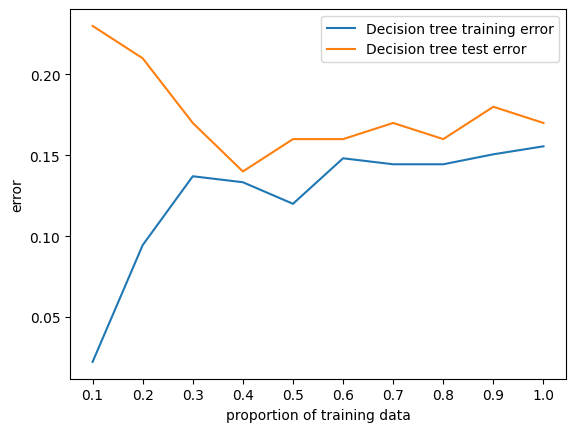

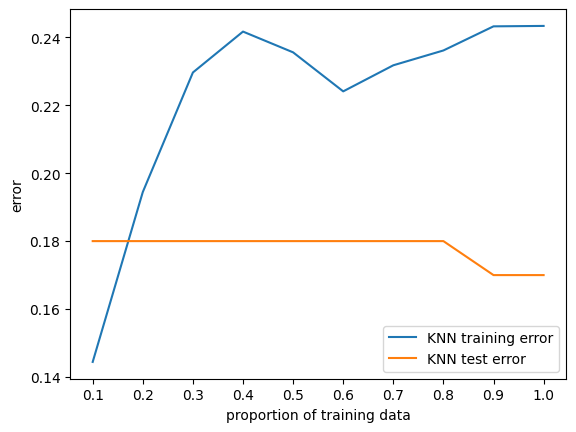

Done


In [11]:
######################################################################
# main
######################################################################


def main():
    # load adult_subsample dataset with correct file path
    ### ========== START ========== ###
    # data_file =  "/content/drive/My Drive/cm146-2024-homeowrks/PS1/adult_subsample.csv" # example path
    data_file = "adult_subsample.csv"  # your path
    ### ========== END ========== ###

    data = load_data(data_file, header=1, predict_col=-1)

    X = data.X
    Xnames = data.Xnames
    y = data.y
    yname = data.yname
    n, d = X.shape  # n = number of examples, d =  number of features

    # ========================================
    # part a: plot histograms of each feature
    print("Plotting...")
    plot_histograms(X, y, Xnames=Xnames, yname=yname)
    plt.show()

    ### ========== START ========== ###
    # part i: Preprocess X (e.g., normalize)
    # (try this after finishing the sections below)

    normalize = False
    if normalize:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

    ### ========== END ========== ###

    # ========================================
    # train Majority Vote classifier on data
    print("Classifying using Majority Vote...")
    clf = (
        MajorityVoteClassifier()
    )  # create MajorityVote classifier, which includes all model parameters
    clf.fit(X, y)  # fit training data using the classifier
    y_pred = clf.predict(X)  # take the classifier and run it on the training data
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print("\t-- training error: %.3f" % train_error)

    ### ========== START ========== ###
    # part b: evaluate training error of Random classifier
    print("Classifying using Random...")
    clf = RandomClassifier()

    clf.fit(X, y)
    y_pred = clf.predict(X)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)

    print("\t-- training error: %.3f" % train_error)
    ### ========== END ========== ###

    ### ========== START ========== ###
    # part c: evaluate training error of Decision Tree classifier
    print("Classifying using Decision Tree...")
    clf = DecisionTreeClassifier(criterion="entropy")

    clf.fit(X, y)
    train_error = 1 - clf.score(X, y)

    print("\t-- training error: %.3f" % train_error)
    ### ========== END ========== ###

    ### ========== START ========== ###
    # part d: evaluate training error of k-Nearest Neighbors classifier
    # use k = 3, 5, 7 for n_neighbors
    print("Classifying using k-Nearest Neighbors...")

    # print the error for each k
    for k in [3, 5, 7]:
        clf = KNeighborsClassifier(n_neighbors=k)

        clf.fit(X, y)
        train_error = 1 - clf.score(X, y)

        print(train_error)

    ### ========== END ========== ###

    ### ========== START ========== ###
    # part e: use cross-validation to compute average training and test error of classifiers
    print("Investigating various classifiers...")

    for clf in [
        MajorityVoteClassifier(),
        RandomClassifier(),
        DecisionTreeClassifier(criterion="entropy"),
        KNeighborsClassifier(),
    ]:
        summary = error(clf, X, y, ntrials=100)
        print(f"{clf.__class__.__name__}: {summary}")

    ### ========== END ========== ###

    ### ========== START ========== ###
    # part f: use 10-fold cross-validation to find the best value of k for k-Nearest Neighbors classifier
    print("Finding the best k...")
    validation_scores = []
    ks = np.arange(1, 50, 2)
    for k in ks:
        clf = KNeighborsClassifier(n_neighbors=k)
        validation_scores.append(cross_val_score(clf, X, y, cv=10).mean())
    best_k = ks[np.argmax(validation_scores)]

    print(f"Best k is {best_k}")
    plt.plot(ks, [1 - score for score in validation_scores])
    plt.xlabel("k")
    plt.xticks(ks)
    plt.ylabel("Validation error")
    plt.show()

    ### ========== END ========== ###

    ### ========== START ========== ###
    # part g: investigate decision tree classifier with various depths
    print("Investigating depths...")
    training_scores = []
    test_scores = []
    depths = np.arange(1, 21)
    for depth in depths:
        clf = DecisionTreeClassifier(criterion="entropy", max_depth=depth)
        cv_results = cross_validate(clf, X, y, cv=10, return_train_score=True)
        training_scores.append(cv_results["train_score"].mean())
        test_scores.append(cv_results["test_score"].mean())
    best_depth = depths[np.argmax(test_scores)]

    print(f"Best depth is {best_depth}")
    plt.plot(depths, [1 - score for score in training_scores], label="Training error")
    plt.plot(depths, [1 - score for score in test_scores], label="Test error")
    plt.xlabel("depth")
    plt.xticks(depths)
    plt.ylabel("error")
    plt.legend()
    plt.show()

    ### ========== END ========== ###

    ### ========== START ========== ###
    # part h: investigate decision tree and k-Nearest Neighbors classifier with various training set sizes
    # hint: use train_test_split (use random_state=0 for consistent results)
    X_train_original, X_test, y_train_original, y_test = train_test_split(
        X, y, test_size=0.1, random_state=0
    )
    decision_tree = DecisionTreeClassifier(criterion="entropy", max_depth=best_depth)
    decision_tree_training_scores = []
    decision_tree_test_scores = []

    knn = KNeighborsClassifier(n_neighbors=best_k)
    knn_training_scores = []
    knn_test_scores = []

    proportions = np.arange(0.1, 1.1, 0.1)
    for training_proportion in proportions:
        X_train = X_train_original[
            : int(training_proportion * X_train_original.shape[0])
        ]
        y_train = y_train_original[: int(training_proportion * len(y_train_original))]

        decision_tree.fit(X_train, y_train)
        decision_tree_training_scores.append(decision_tree.score(X_train, y_train))
        decision_tree_test_scores.append(decision_tree.score(X_test, y_test))

        knn.fit(X_train, y_train)
        knn_training_scores.append(knn.score(X_train, y_train))
        knn_test_scores.append(knn.score(X_test, y_test))

    plt.plot(
        proportions,
        [1 - score for score in decision_tree_training_scores],
        label="Decision tree training error",
    )
    plt.plot(
        proportions,
        [1 - score for score in decision_tree_test_scores],
        label="Decision tree test error",
    )
    plt.xlabel("proportion of training data")
    plt.xticks(proportions)
    plt.ylabel("error")
    plt.legend()
    plt.show()

    plt.plot(
        proportions,
        [1 - score for score in knn_training_scores],
        label="KNN training error",
    )
    plt.plot(
        proportions, [1 - score for score in knn_test_scores], label="KNN test error"
    )
    plt.xlabel("proportion of training data")
    plt.xticks(proportions)
    plt.ylabel("error")
    plt.legend()
    plt.show()

    ### ========== END ========== ###

    print("Done")


if __name__ == "__main__":
    main()